In [1]:

import praw
import time
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from prawcore.exceptions import RequestException, ResponseException, Forbidden

reddit = praw.Reddit(
    client_id="gs4u-qKMtljY9Lt2ZA1UAA",
    client_secret="yPvyMDcvhVNTspyIcPiYc5zPAbB89Q",
    user_agent="reddit_network_analysis by /u/disabledmineman"
)


In [3]:

subreddits = [
    "gaming",
    "pcgaming",
    "xbox",
    "PlayStation",
    "NintendoSwitch",
    "Steam",
    "Minecraft",
    "FortniteBR",
    "leagueoflegends",
    "VALORANT",
    "DestinyTheGame",
    "Overwatch",
    "Genshin_Impact",
    "pokemon",
    "RocketLeague"
]

In [ ]:

def fetch_active_users(sub_name, limit=2000):
    users = set()
    print(f"📡 Fetching r/{sub_name} ...")
    attempts = 0

    while attempts < 3:
        try:
            subreddit = reddit.subreddit(sub_name)

            for submission in subreddit.new(limit=limit):
                if submission.author:
                    users.add(submission.author.name)

            for comment in subreddit.comments(limit=limit):
                if comment.author:
                    users.add(comment.author.name)

            print(f"✅ {sub_name}: {len(users)} users")
            return users

        except (RequestException, ResponseException, Forbidden):
            attempts += 1
            print(f"Retry {attempts}/3...")
            time.sleep(3)

    print(f"Failed {sub_name}")
    return users

active_users = {}
for sub in subreddits:
    active_users[sub] = fetch_active_users(sub)
    time.sleep(2.5)


📡 Fetching r/gaming ...
✅ gaming: 1362 users
📡 Fetching r/pcgaming ...
✅ pcgaming: 1082 users
📡 Fetching r/xbox ...
✅ xbox: 1228 users
📡 Fetching r/PlayStation ...
✅ PlayStation: 1537 users
📡 Fetching r/NintendoSwitch ...
✅ NintendoSwitch: 1064 users
📡 Fetching r/Steam ...
✅ Steam: 1682 users
📡 Fetching r/Minecraft ...
✅ Minecraft: 1443 users
📡 Fetching r/FortniteBR ...
✅ FortniteBR: 1413 users
📡 Fetching r/leagueoflegends ...
✅ leagueoflegends: 1375 users
📡 Fetching r/VALORANT ...
✅ VALORANT: 1280 users
📡 Fetching r/DestinyTheGame ...
✅ DestinyTheGame: 1271 users
📡 Fetching r/Overwatch ...
✅ Overwatch: 1481 users
📡 Fetching r/Genshin_Impact ...
✅ Genshin_Impact: 1423 users
📡 Fetching r/pokemon ...
✅ pokemon: 1458 users
📡 Fetching r/RocketLeague ...
✅ RocketLeague: 1347 users


In [10]:

G = nx.Graph()
for sub in subreddits:
    G.add_node(sub)

for i in range(len(subreddits)):
    for j in range(i + 1, len(subreddits)):
        s1, s2 = subreddits[i], subreddits[j]
        overlap = active_users[s1].intersection(active_users[s2])
        if len(overlap) >= 5:
            G.add_edge(s1, s2, weight=len(overlap))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 15, Edges: 29


,Subreddit,Degree Centrality,Betweenness Centrality
0,gaming,0.642857,0.120879
2,xbox,0.500000,0.065934
3,PlayStation,0.500000,0.137363
7,FortniteBR,0.428571,0.324176
1,pcgaming,0.357143,0.000000
4,NintendoSwitch,0.357143,0.000000
5,Steam,0.357143,0.000000
6,Minecraft,0.214286,0.032967
13,pokemon,0.214286,0.000000
8,leagueoflegends,0.142857,0.010989


Top 3 hubs: ['gaming', 'xbox', 'PlayStation']


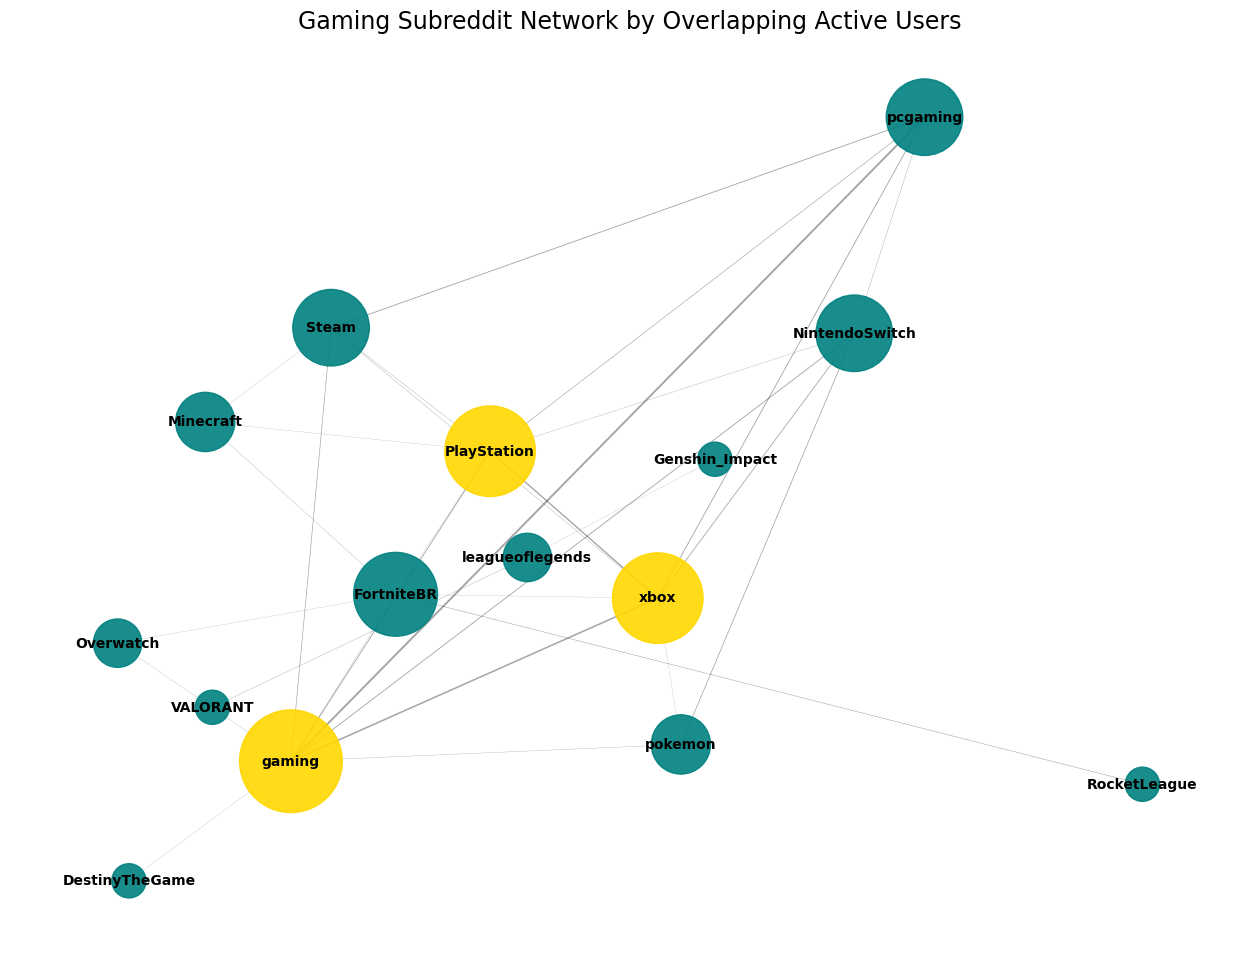

In [12]:

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")

centrality_df = pd.DataFrame({
    "Subreddit": list(degree_centrality.keys()),
    "Degree Centrality": list(degree_centrality.values()),
    "Betweenness Centrality": list(betweenness_centrality.values())
}).sort_values("Degree Centrality", ascending=False)

display(centrality_df)

top3 = centrality_df["Subreddit"].head(3).tolist()
print("Top 3 hubs:", top3)

pos = nx.kamada_kawai_layout(G)
node_colors = ["gold" if n in top3 else "teal" for n in G.nodes()]
node_sizes = [8500 * degree_centrality[n] for n in G.nodes()]
edge_weights = [G[u][v]["weight"] * 0.035 for u, v in G.edges()]

plt.figure(figsize=(16, 12))
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.35)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Gaming Subreddit Network by Overlapping Active Users", fontsize=17)
plt.axis("off")
plt.show()
